# Training Tension Models
---
> Graph neural network model for vertex dynamics and tension prediction

**To-Do**👷🚧
- Find good features `x_v` (nodes) and `x_e` (edges)
    - `x_v`:node features to try:
        - [ ] The **Cartesian `u=(x,y)` coordinates**: find number of past velocities (window size `w`). 
        - [ ] The **append norm `[|u|, u_1, u_2]`**, where I separate length from direction (vector). Same `w`.
    - `x_e`: edge features to try:
        - [ ] add **edge length changes** (ie `x_e = dl(t; t=T-1...T-w), e[s,t]` ); edge vector (`e[s,t] = v_pos[t]-v_pos[s]`).
        $\{l_{ij}(t)\}_{t=T-1...T-w } = (x_v[tgt]- x_v[src])$
- Model architecture:
    - [ ] add *Cell layer* processor
- Rollout error (tension, position/velocity)
    - rollout vs 1-step losses
    - train for single step with velocity noise (Brownian noise: Sanchez-Gonzalez, *et al.* \[ASG2020\])
    - train for rollout (multi-step loss)
    - convert vel-y error to **position error**, e.g. "speed"+"direction"(angle/dot product etc.)
- compare MLP vs CONV layers for message passing.
- try with dynamic graphs (construct graphs on the fly based on relative positions, and use cell edges and cell attrib only for queries on `Y_edge`, `Y_cell`).

**Node-to-Cell Encoding/Pooling Layer**:
1. Initiate node-to-cell edge attr-s as (source) node attr-s `x[node2cell_index[0]]`.
1. Compute node-to-cell edge attr-s using MLP: `e_n2c = MLP( x[node2cell_index[0]] )`
1. Aggregate node-to-cell edge attr-s as cell attr-s : `x_cell = Aggregate(e_n2c)`
1. Compute new cell attr-s using (encodes `x_cell` into cell attr-s) : `h_cell = MLP_Cell_encoder( x_cell )`

```python
n2c_model = mlp(...) # "message", just node-wise MLP
cell_aggr = Aggregate()
cell_enc = mlp(...)

e_n2c = n2c_model(data.x)[data.node2cell_index[0]]
x_cell = cell_aggr(data.cell_pressures.size(0), data.node2cell_index, e_n2c)
h_cell = cell_enc(x_cell)
```

---
- **Adding noise from M steps**: Sum of M normal rand. var-s results in normal var. w/ variance M and s.t.d.=sqrt(M):
```python
x = np.random.normal(size=(5,1000))
y = x.sum(axis=0)
z = np.random.normal(size=(1,1000))*np.sqrt(5)
plt.hist(x.ravel(),bins=50,label='x',density=True)
plt.hist(y        ,bins=50,label='y',density=True)
plt.hist(z.ravel(),bins=50,label='z',density=True,alpha=.5)
plt.legend();
```

---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [33]:
from collections import OrderedDict
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies, HaraAblation
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, RecoilAsTension
from simgnn.transforms import AppendReversedEdges, AppendEdgeNorm, AppendDiff_x, Reshape_x, AppendEdgeLen
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Data, Stat-s, Transforms

Notes for normalisation param-s:

- Use `simgnn.transforms` to normalise real--Hara movies and ablation,  and simulated movies.
- For ablation movies, convert to  HaraMovies length scale (pixels) and use same `l_av` as for HaraMovies dataset.

---
|Dataset| Avg. edge len.|Tension/Recoil| Transforms (Normalisation)|Notes|
|:---:|:---:|---:|:---|:---:|
|`single_distr_sims` | 1.08 a.u. | range = [0.00131, 4.26]; sd=0.637; median=0.305; mean=0.578; | `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)]`| synthetic; w/o base tension |
|`unimodal_wbasetens_sims` | 0.906 a.u. | range=[0.407, 5.47]; sd=0.729; median=1.48; mean=1.6| `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)]`| synthetic; w/ non-zero base tension |
|`HaraMovies`  | 26.32 pixels||`[Pos2Vec(scale=10*26.32)`, `ScaleVelocity(0.5*26.32)]`| tissue movies w/o force data|
|`HaraAblation`|$26.32\cdot\frac{0.4}{0.21}$ pixels| range=[0.0239, 2.61]; sd=0.651; median=0.673; mean=0.826 | `[Pos2Vec(scale=10*50.13), ScaleVelocity(0.5*50.13)]`| short movies w/ recoil data; frame rate:dataset contains vertex positions only from every 10th frame |


### Datasets

---
- **Normalisation param-s**

In [34]:
# Data normalisation param-s : sim="default" for simulation data
# Average edge lengths
l_0 = {'sim':1.0, 'single_distr_sims':1.1, 'unimodal_wbasetens_sims':0.91, 'hara':26.32, 'abln':50.13}

# Stat-s for raw tension/recoil values
t_av = {'sim':0.6, 'single_distr_sims': 0.58, 'unimodal_wbasetens_sims': 1.6, 'abln': 0.83}
t_sd = {'sim':0.63, 'single_distr_sims': 0.64, 'unimodal_wbasetens_sims':0.73 , 'abln': 0.65}

**Input features and normalisation param-s (transforms)**

In [35]:
# Input features
window_size = 5
print(f'> Set features window size to --> {window_size}')

# Simulation dataset
Tnrm = {k: [Pos2Vec(scale=10*l_0[k]) , ScaleVelocity(0.5*l_0[k]), ScaleTension(t_sd[k], shift=t_av[k])]
        for k in ['sim', 'single_distr_sims', 'unimodal_wbasetens_sims']}

# Hara ablation dataset
Tnrm['abln'] = [Pos2Vec(scale=10*l_0['abln']), ScaleVelocity(0.5*l_0['abln']),
                RecoilAsTension(), 
                #ScaleTension(t_sd['abln'], shift=t_av['abln'])
               ]

# Hara movie dataset
Tnrm['hara'] = [Pos2Vec(scale=10*l_0['hara']) , ScaleVelocity(0.5*l_0['hara'])]

# Node and Edge Feature Transforms
for k in Tnrm:
    # to undirected graph: add e_ji for all e_ij
    Tnrm[k].append(AppendReversedEdges())
    
    # Add edge features
    Tnrm[k].append(AppendDiff_x())
    Tnrm[k].append(AppendEdgeNorm())
    Tnrm[k].append(AppendEdgeLen(norm=True, scale=l_0[k])) # for edge masks
    
    # flatten  node features
    Tnrm[k].append(Reshape_x((-1,window_size*2)))
    
    Tnrm[k] = T.Compose(Tnrm[k])

> Set features window size to --> 5


In [38]:
Tnrm['sim']

Compose([
    Pos2Vec(norm=True, scale=10.0, cat=False),
    ScaleVelocity(scale=0.5),
    ScaleTension(scale=0.63, shift=0.6),
    AppendReversedEdges(reverse_attr=True, reverse_tension=False, edge_id=True),
    AppendDiff_x(norm=True),
    AppendEdgeNorm(N_dim=2),
    AppendEdgeLen(keep_dir=False, aggr_edge_id=True, use_edge_attr=False, norm=True, scale=1.0),
    Reshape_x((-1, 10)),
])

**Load datasets**

- if a new `w` parameter is set, delete the older *processed* dataset files

In [39]:
!rm -dr simgnn_data/single_distr_sims/train/processed
!rm -dr simgnn_data/single_distr_sims/val/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed

!rm -dr simgnn_data/hara_movies/processed/
!rm -dr simgnn_data/hara_ablation/processed/

# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/

In [40]:
hara_abln = HaraAblation('simgnn_data/hara_ablation/', window_size=window_size, transform=Tnrm['abln'], smoothing=True, sma_lag_time=3)
hara = HaraMovies('simgnn_data/hara_movies/',window_size=window_size, transform=Tnrm['hara'], smoothing=True, sma_lag_time=4)

# Hara movie datasets
# seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara)
# seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)

# Simulation datasets
# rand base contractility
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size,
#                       transform=Tnrm['sim']
                      transform=Tnrm['unimodal_wbasetens_sims']
                     )
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size,
#                           transform=Tnrm['sim']
                          transform=Tnrm['unimodal_wbasetens_sims']
                         )

# w/o base contractility
sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size,
#                       transform=Tnrm['sim']
                      transform=Tnrm['single_distr_sims']
                     )
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size,
#                           transform=Tnrm['sim']
                          transform=Tnrm['single_distr_sims']
                         )


datasets_dict = {'train': sim1,
                 'val': sim1_val,
                 'val2': sim2_val,
                 'hara' : hara,
                 'abln': hara_abln}
dataset_legend={'train': 'Train(sim1)',
                'val': 'Val(sim1)',
                'val2': 'Val(sim2)',
                'hara': 'Hara',
                'abln': 'Recoil'}

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [41]:
sim1[0]

CellData(cell2node_index=[2, 480], cell_pressures=[80], edge_attr=[550, 18], edge_id=[550], edge_index=[2, 550], edge_length=[275], edge_tensions=[275], node2cell_index=[2, 480], pos=[196, 2], x=[196, 10], y=[196, 2])

In [121]:
# k = 'val2'
# t = 15
# print('{}\n{} : {}\nsize:{}\n\nFrame {}:\n{}'.format(dataset_legend[k],k,datasets_dict[k],len(datasets_dict[k]),t,datasets_dict[k][0]))
# plt.figure(figsize=[2.5,2.5])
# nx.draw(to_networkx(datasets_dict[k][t]),pos=dict(enumerate(datasets_dict[k][t].pos.numpy())), node_size=10)

**Persistence Losses**

In [122]:
# print('Persistence:')
# for k in datasets_dict:
#     if k=='abln':print('Ignoring ablation data velocity');continue
#     print(f'\t- {dataset_legend[k]}: {persistence_loss(datasets_dict[k])}')
    
# print(len(datasets_dict['train']))

---

## Tension Models

In [56]:
from simgnn.train import train_model, write_log, load_log, plot_losses
from simgnn.train import predict, predict_batch, plot_velocity_predictions, plot_tension_prediction
from simgnn.train import predict_abln_tension, predict_dataset_tension

from scipy.stats import pearsonr


# from simgnn.nn import mlp, IndependentBlock, MessageBlock, dims_to_dict, Encode_Process_Decode
from simgnn.models import construct_simple_gnn, GraphEncoder, GraphDecoder, GraphProcessor

In [12]:
# MessageBlock(..., hidden_dims=[16], updt='p')

In [13]:
# next(iter(loaders['train']))

- Construct a model

In [14]:
# torch.manual_seed(0)

# # GNN architecture (if dim is `int` latent dims nodes=edges)
# # -----
# input_dims = OrderedDict([('node', 10), ('edge', 2)]) # node_features, edge_features
# output_dims = OrderedDict([('node', 2), ('edge', 1)]) # velocity:(Nv,2), tensions:(Ne,1)
# latent_dims = 128

# encoder_kwrgs    = {'hidden_dims':[64]}

# processor_kwargs = {'n_blocks': 10,
#                     'block_type': 'message',
#                     'is_residual': True,
#                     'seq': 'n', # 'n', 'e', 'p'
#                     'norm_type': 'bn', # 'ln' or 'bn'
#                     'block_p': 0,  # block dropout (last layer)
#                     'dropout_p': 0, # dropout for hidden layers (if any)
#                     'hidden_dims':[64]
#                    }

# decoder_kwargs   = {'hidden_dims':[64, 32, 8]}

# net = construct_simple_gnn(input_dims, latent_dims, output_dims,
#                            encoder_kwrgs=encoder_kwrgs,
#                            processor_kwargs=processor_kwargs, 
#                            decoder_kwargs=decoder_kwargs).to(device)

# unique_id = 'NoNrmNoDiffX'#net.__class__.__name__  # set unique name for the model
# save_dir = './simgnn_data/saved_models/'

In [43]:
import simgnn.hardcoded as hcmodels # hardcoded models for testing and experimentation

torch.manual_seed(0)
# net, unique_id = hcmodels.get_model_04122021()
net, unique_id = hcmodels.get_model_YesNrmYesDiffX(return_name=True)
print('unique_id:', unique_id)
net = net.to(device)

# unique_id: 'YesNrmYesDiffX', 'NoNrmNoDiffX', 'YesNrmNoDiffX', 'model_04122021'

# save_dir = './simgnn_data/saved_models/tension_test'
save_dir = './simgnn_data/saved_models/'

unique_id: YesNrmYesDiffX


- Training param-s and loaders:

In [44]:
# Training param-s & Data loaders:
# -----
num_epochs = 20
lr = 0.0001
bs = 2
loss_func = torch.nn.MSELoss(reduction='mean')

opt = torch.optim.Adam(net.parameters(), lr=lr) # SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = None # torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs),
           'val':    DataLoader(datasets_dict['val'],  batch_size=bs)
          }
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {'train':[True,False], 
                  'val':[True, False],
                  'val2':[True,False] ,
                  'abln':[True,False] ,
                  'hara' : [False, False]
                 }# [tension, pressure]

return_best = False
ignore_short_edges, edge_len_threshold = False, 10**-4


model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{unique_id}_bs{bs}w{window_size}{"best" if return_best else ""}'
print(model_name)

20122021_023747_YesNrmYesDiffX_bs2w5


In [45]:
print(model_name,end='\n---\n')

net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=scheduler, device=device, model_states = model_states,
                             loss_func = loss_func, use_force_loss=use_force_loss, return_best=return_best,
                             ignore_short_edges = ignore_short_edges, edge_len_threshold = edge_len_threshold)

20122021_023747_YesNrmYesDiffX_bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot=  0.8063; train_loss_y= 0.01059; train_loss_T=  0.7957; |val_loss_tot=  0.7554; |8s
Epoch 1/19: train_loss_tot=  0.5253; train_loss_y=0.006337; train_loss_T=  0.5189; |val_loss_tot=  0.5172; |16s
Epoch 2/19: train_loss_tot=  0.4459; train_loss_y=0.005083; train_loss_T=  0.4408; |val_loss_tot=   0.464; |24s
Epoch 3/19: train_loss_tot=  0.4159; train_loss_y=0.004483; train_loss_T=  0.4114; |val_loss_tot=  0.4836; |32s
Epoch 4/19: train_loss_tot=  0.3941; train_loss_y=0.004129; train_loss_T=    0.39; |val_loss_tot=   0.486; |39s
Epoch 5/19: train_loss_tot=  0.3745; train_loss_y=0.003973; train_loss_T=  0.3706; |val_loss_tot=  0.4738; |47s
Epoch 6/19: train_loss_tot=  0.3561; train_loss_y=0.003841; train_loss_T=  0.3523; |val_loss_tot=  0.4825; |55s
Epoch 7/19: train_loss_tot=  0.3376; train_loss_y=0.003717; train_lo

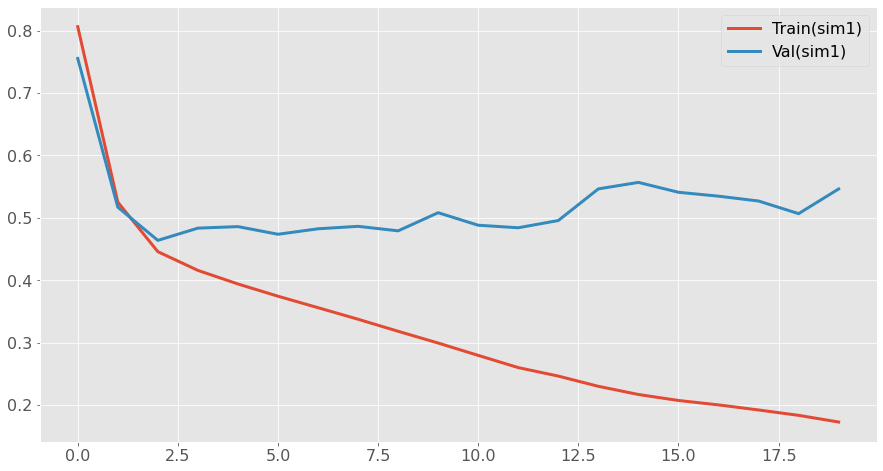

In [46]:
# plot losses
plot_losses(train_log, loaders, dataset_legend)
# plt.show()

In [47]:
# # # Save trained model # # #
# write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
# torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')
# print(f'Model weights saved in \n{path.join(save_dir, model_name)}_net.pkl')

In [1]:
# compute predictions and plot them
# vel-y, tens, pres
bs = 2

pred_out, tgt_out, sample_losses = predict_batch(net,
                                                 {
                                                  'train' : DataLoader(datasets_dict['train'], batch_size=bs),
                                                  'val':    DataLoader(datasets_dict['val'],  batch_size=bs),
                                                  'val2':   DataLoader(datasets_dict['val2'], batch_size=bs),
                                                  'hara':   DataLoader(datasets_dict['hara'], batch_size=bs)},
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {'train': True, 'val': True, 'val2': True, 'hara': False},
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

axs = plot_tension_prediction(pred_out[1], tgt_out[1], dataset_legend,figsize=[15,15],nrows=2,ncols=2)

# # # # # # # # # # # # # #
# # # Hara Ablation # # # #
# # # # # # # # # # # # # #
Tp, Tt, is_ros_ = predict_abln_tension(net, datasets_dict['abln'], device=device)

m1,m2 = np.polyfit(Tt[~is_ros_], Tp[~is_ros_], 1)
y_fit = np.array([min(Tt),max(Tt)])*m1+m2

# plt.figure(figsize=[6,6])
ax = axs.ravel()[-1]
ax.plot(Tt[~is_ros_], Tp[~is_ros_], 'o', mfc='tomato', ms=7, alpha=.5, label='w/o rosettes')
ax.plot(Tt[is_ros_], Tp[is_ros_], 'o', mfc='royalblue', ms=10, alpha=.5, label='rosettes')

ax.plot([min(Tt),max(Tt)], y_fit, 'k--',lw=3, alpha=.5, label=f'$f(x)={m1:.3f}x{"+" if m2>0 else "-"}{np.abs(m2):.3f}$')
ax.set_title('Recoil vs Predicted Tension');
ax.set_xlabel('Recoil');
ax.set_ylabel('Tension(pred)');
ax.axis([min(Tt),max(Tt), y_fit[0], y_fit[1]])
ax.legend();

plt.show()
print('- '*10+'-')
print(f'NO___rosettes : R,p={pearsonr(Tt[~is_ros_], Tp[~is_ros_])}')
print(f'WITH_rosettes : R,p={pearsonr(Tt, Tp)}')
print('- '*10+'-')

NameError: name 'predict_batch' is not defined

---

**Check tension prediction, losses, and plots**

train MSE: 0.3262779824911215
val MSE: 0.5517736564075297
val2 MSE: 0.6412662931532331


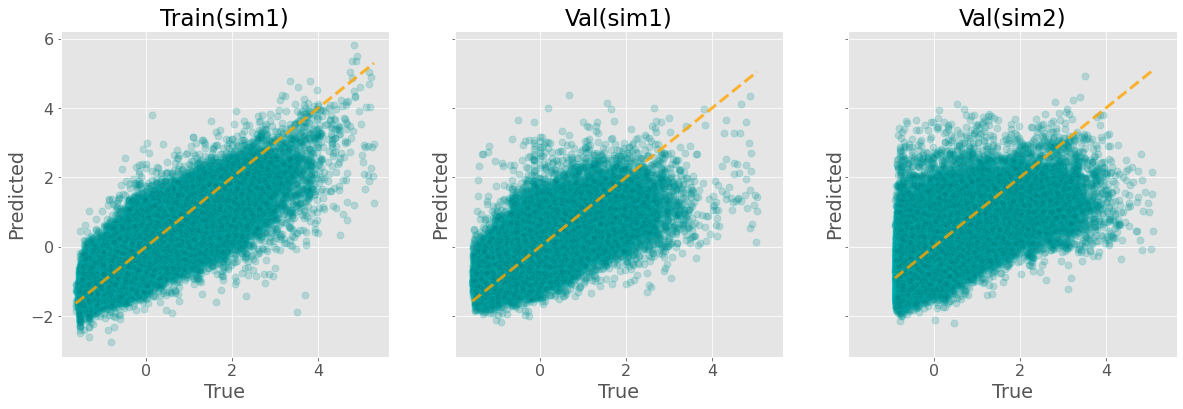

In [52]:
# # Predict for each sample w/o batching:

_, axs = plt.subplots(ncols=3, figsize=[20, 6], sharex=True, sharey=True)

tension_preds = {}
tension_trues = {}

for dataset_k, ax in zip(['train', 'val', 'val2'], axs):
    Tp, Tt =  predict_dataset_tension(net, datasets_dict[dataset_k],device=device)
    tension_preds[dataset_k] = Tp
    tension_trues[dataset_k] = Tt

    minmaxY = [np.min(np.concatenate([k.ravel() for k in Tt])),
               np.max(np.concatenate([k.ravel() for k in Tt]))] 

    ax.plot(np.concatenate([k.ravel() for k in Tt]),
            np.concatenate([k.ravel() for k in Tp]),
            'o', ms=7, c='c', mfc='teal', alpha=.2)
    ax.plot(minmaxY, minmaxY, '--', color='orange', lw=3, alpha=.8)
    ax.set_title(dataset_legend[dataset_k]);
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    
    sum_l2_losses, Nsamples = np.array([(((Tp_k-Tt_k)**2).sum(), Tp_k.shape[1])
                                    for Tp_k, Tt_k in zip(tension_preds[dataset_k], tension_trues[dataset_k])]).sum(axis=0)
    print(f'{dataset_k} MSE:', sum_l2_losses/Nsamples)

In [53]:
dataset_k = 'train'

l2_loss = torch.nn.MSELoss(reduction='mean')
print('torch.nn.MSE:', l2_loss(torch.from_numpy(np.concatenate([T_k.ravel() for T_k in tension_trues[dataset_k]])),
                               torch.from_numpy(np.concatenate([T_k.ravel() for T_k in tension_preds[dataset_k]]))) )

torch.nn.MSE: tensor(0.3263)
